# stock7_mra
* mra：Multiple Regression Anarysis（重回帰分析）
## 概要
### 予測モデル
* 木曜日の各種情報を元に、金曜日の終値を予測する
### 処理
* yahoo financeより株価データを取得する
* 株価データを用いて、予測モデルを構築する
  * 予測モデルの構築には、線形回帰（重回帰）を用いる
* 予測モデルを評価する
## 参考
### キノコード：株価のデータ分析(7)
* https://youtu.be/cZYFJAioZgc
* https://kino-code.com/python-stock-price2/
### install packages
* pip install pandas_datareader
* pip install yfinance
* pip install tensorflow

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

# 最大表示行数の指定(任意:ここでは10行を指定)
pd.set_option('display.max_rows', 10)

In [2]:
# 日経平均データ（~N225）の取得
ticker = '^N225'
start = '2018-01-01'
end = '2021-12-31'

yf.pdr_override()
data_master = pdr.get_data_yahoo(ticker, start, end)

# 曜日情報を追加(0:月曜日〜4:金曜日)
data_master['weekday'] = data_master.index.weekday
data_master

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,weekday
Date,,,,,,,
2018-01-04,23073.730469,23506.330078,23065.199219,23506.330078,23506.330078,102200000,3
2018-01-05,23643.000000,23730.470703,23520.519531,23714.529297,23714.529297,101900000,4
2018-01-09,23948.970703,23952.609375,23789.029297,23849.990234,23849.990234,94100000,1
2018-01-10,23832.810547,23864.759766,23755.449219,23788.199219,23788.199219,88800000,2
2018-01-11,23656.390625,23734.970703,23601.839844,23710.429688,23710.429688,83700000,3
...,...,...,...,...,...,...,...
2021-12-24,28836.050781,28870.130859,28773.500000,28782.589844,28782.589844,35900000,4
2021-12-27,28786.330078,28805.279297,28658.820312,28676.460938,28676.460938,37500000,0
2021-12-28,28953.320312,29121.009766,28879.679688,29069.160156,29069.160156,47000000,1


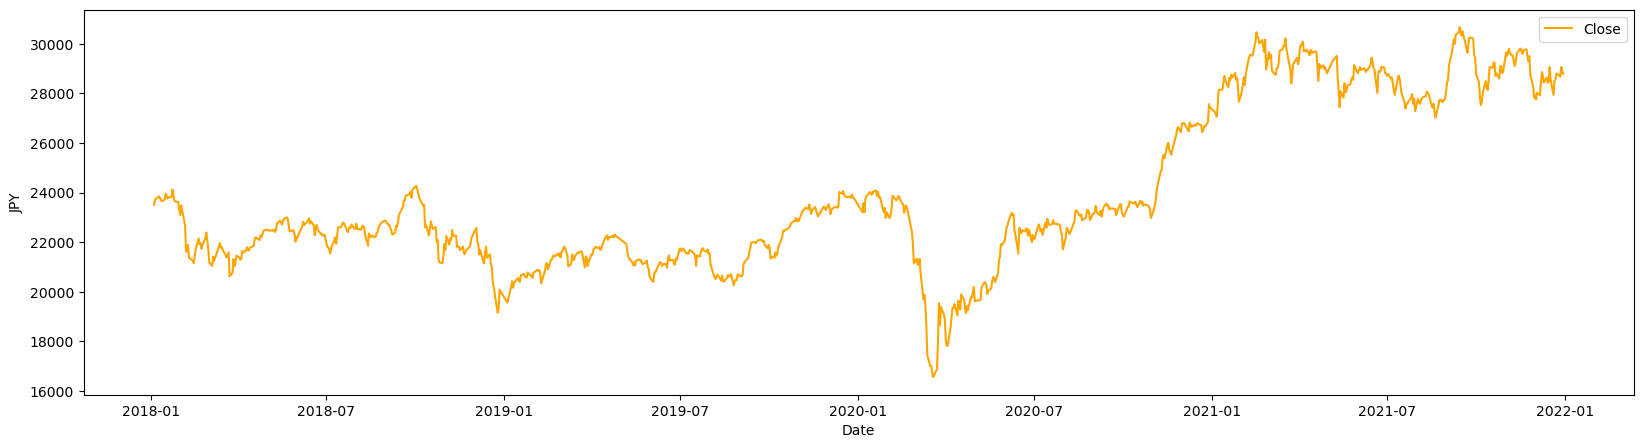

In [3]:
# グラフの描画
plt.figure(figsize=(20, 5))
plt.plot(data_master['Close'], label='Close', color='orange')
plt.xlabel('Date')
plt.ylabel('JPY')
plt.legend()
plt.show()

### 説明変数の追加と目的変数の設定
* ファイナンス分析でよく使用される指標として、以下の説明変数を追加する
  * 移動平均
  * 実体
  * 終値の前日差分

In [4]:
# data_techinicalにデータをコピー
data_technical = data_master.copy()

# 移動平均を追加
SMA1 = 5   #短期5日
SMA2 = 10  #中期10日
SMA3 = 15  #長期15日
data_technical['SMA1'] = data_technical['Close'].rolling(SMA1).mean() #短期移動平均の算出
data_technical['SMA2'] = data_technical['Close'].rolling(SMA2).mean() #中期移動平均の算出
data_technical['SMA3'] = data_technical['Close'].rolling(SMA3).mean() #長期移動平均の算出

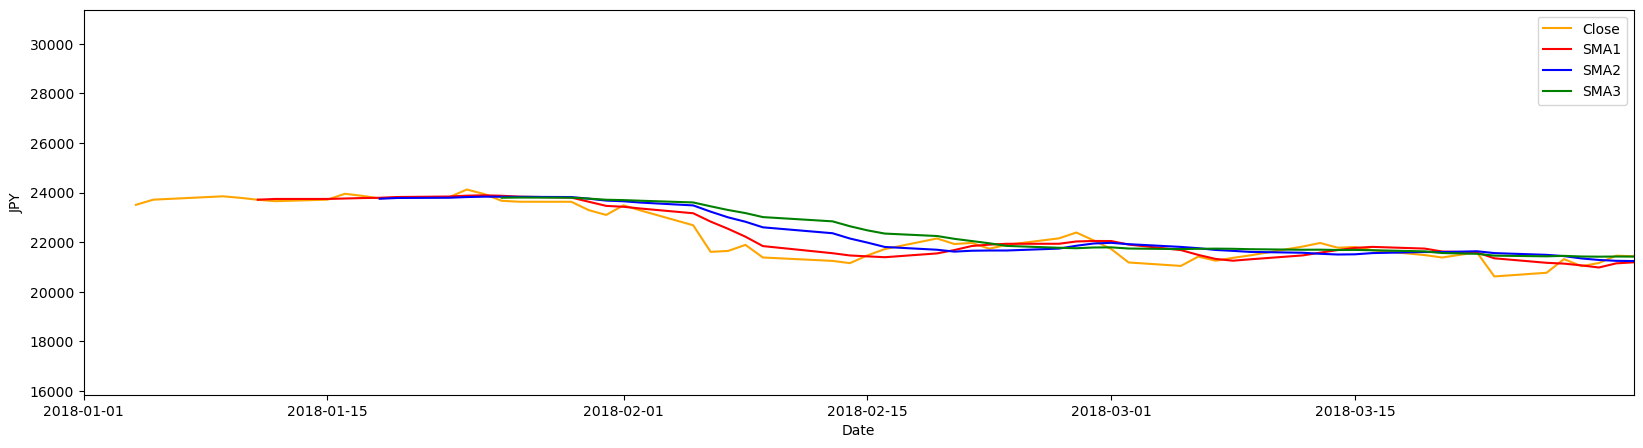

In [5]:
# 特徴量を描画して確認(x軸の拡大)
plt.figure(figsize=(20, 5))
plt.plot(data_technical['Close'], label='Close', color='orange')
plt.plot(data_technical['SMA1'], label='SMA1', color='red')
plt.plot(data_technical['SMA2'], label='SMA2', color='blue')
plt.plot(data_technical['SMA3'], label='SMA3', color='green')
plt.xlabel('Date')
plt.ylabel('JPY')
plt.legend()
xmin = datetime(2018,1,1)
xmax = datetime(2018,3,31)
plt.xlim([xmin,xmax])
plt.show()

In [6]:
# OpenとCloseの差分を実体（Body）として計算
#data_technical['Body'] = data_technical['Open'] - data_technical['Close']
data_technical['Body'] = data_technical['Close'] - data_technical['Open']
# 終値と前日終値との差分（Close_diff）を計算
#data_technical['Close_diff'] = data_technical['Close'].diff(1)
data_technical['Close_diff'] = data_technical['Close'] - data_technical['Close'].diff(1)
# 目的変数となる翌日の終値（Close_next）の追加
data_technical['Close_next'] = data_technical['Close'].shift(-1)
data_technical

,Open,High,Low,Close,Adj Close,Volume,weekday,SMA1,SMA2,SMA3,Body,Close_diff,Close_next
Date,,,,,,,,,,,,,
2018-01-04,23073.730469,23506.330078,23065.199219,23506.330078,23506.330078,102200000,3,NaN,NaN,NaN,432.599609,NaN,23714.529297
2018-01-05,23643.000000,23730.470703,23520.519531,23714.529297,23714.529297,101900000,4,NaN,NaN,NaN,71.529297,23506.330078,23849.990234
2018-01-09,23948.970703,23952.609375,23789.029297,23849.990234,23849.990234,94100000,1,NaN,NaN,NaN,-98.980469,23714.529297,23788.199219
2018-01-10,23832.810547,23864.759766,23755.449219,23788.199219,23788.199219,88800000,2,NaN,NaN,NaN,-44.611328,23849.990234,23710.429688
2018-01-11,23656.390625,23734.970703,23601.839844,23710.429688,23710.429688,83700000,3,23713.895703,NaN,NaN,54.039062,23788.199219,23653.820312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,28836.050781,28870.130859,28773.500000,28782.589844,28782.589844,35900000,4,28519.714062,28574.342187,28543.350000,-53.460938,28798.369141,28676.460938
2021-12-27,28786.330078,28805.279297,28658.820312,28676.460938,28676.460938,37500000,0,28667.444141,28577.939258,28593.289453,-109.869141,28782.589844,29069.160156
2021-12-28,28953.320312,29121.009766,28879.679688,29069.160156,29069.160156,47000000,1,28777.758203,28641.591211,28634.193490,115.839844,28676.460938,28906.880859


In [7]:
# 欠損値がある行を削除
data_technical = data_technical.dropna(how='any')

# 木曜日のデータを抜き出す
data_technical = data_technical[data_technical['weekday'] == 3]

# 必要なカラムを抽出
data_technical = data_technical[['High', 'Low', 'Open', 'Close', 'Body',
                    'Close_diff', 'SMA1', 'SMA2', 'SMA3', 'Close_next']]
data_technical

,High,Low,Open,Close,Body,Close_diff,SMA1,SMA2,SMA3,Close_next
Date,,,,,,,,,,
2018-01-25,23828.400391,23649.029297,23750.650391,23669.490234,-81.160156,23940.779297,23871.762109,23831.103125,23792.033984,23631.880859
2018-02-01,23492.769531,23211.119141,23276.099609,23486.109375,210.009766,23098.289062,23427.517969,23649.640039,23696.574740,23274.529297
2018-02-08,21977.029297,21649.699219,21721.570312,21890.859375,169.289062,21645.369141,22220.615625,22824.066797,23173.298568,21382.619141
2018-02-15,21578.990234,21308.919922,21384.099609,21464.980469,80.880859,21154.169922,21427.461719,21983.563672,22477.107161,21720.250000
2018-02-22,21799.400391,21626.849609,21789.880859,21736.439453,-53.441406,21970.810547,21900.362109,21663.911914,21955.829818,21892.779297
...,...,...,...,...,...,...,...,...,...,...
2021-11-25,29570.419922,29444.449219,29469.650391,29499.279297,29.628906,29302.660156,29584.115625,29608.165820,29559.125911,28751.619141
2021-12-02,27938.550781,27644.960938,27716.199219,27753.369141,37.169922,27935.619141,28109.257422,28846.686523,29108.529687,28029.570312
2021-12-09,28908.289062,28725.470703,28827.320312,28725.470703,-101.849609,28860.619141,28399.725781,28254.491602,28697.699609,28437.769531


### 学習用データとテストデータに分割
* 2018年1月から2020年12月までの3年分のデータを学習用データとする
* 2021年1月から2021年12月までの1年分をテストデータとする

In [8]:
# 2018年〜2020年を学習用データとする
train = data_technical['2018-01-01' : '2020-12-31']

# 2021年をテストデータとする
test = data_technical['2021-01-01' :]

# 学習用データとテストデータそれぞれを説明変数と目的変数に分離する
X_train = train.drop(columns=['Close_next']) #学習用データ説明変数
y_train = train['Close_next'] #学習用データ目的変数
X_test = test.drop(columns=['Close_next']) #テストデータ説明変数
y_test = test['Close_next'] #テストデータ目的変数

### モデル作成と精度検証
* 予測モデルを作成する際には、実際に使用できるモデルかどうかの、予測精度を検討する必要がある
* この時、交差検証を行うことが有効と考えられる
* 交差検証とは、学習用データを学習データと検証データに分割し、学習データと検証データの組み合わせを変えながらモデルの学習と予想を繰り返し行い、精度検証を行う
* 交差検証のやり方は様々あるが、今回の様にデータが日付順に並んだ時系列データを用いて、過去のデータから未来を予測する場合は、時系列交差検証を行うことがある
* 今回は、学習データを時系列に5分割し、データの組み合わせを変えて合計4回のモデル作成から精度検証を繰り返し行う

In [9]:
# 線形回帰モデルのLinearRegressionをインポート
from sklearn.linear_model import LinearRegression
# 時系列分割のためTimeSeriesSplitのインポート
from sklearn.model_selection import TimeSeriesSplit
# 予測精度検証のためMSEをインポート
from sklearn.metrics import mean_squared_error as mse

In [10]:
# 時系列分割交差検証
valid_scores = []
tscv = TimeSeriesSplit(n_splits=4)
for fold, (train_indices, valid_indices) in enumerate(tscv.split(X_train)):
    X_train_cv, X_valid_cv = X_train.iloc[train_indices], X_train.iloc[valid_indices]
    y_train_cv, y_valid_cv = y_train.iloc[train_indices], y_train.iloc[valid_indices]
    # 線形回帰モデルのインスタンス化
    model = LinearRegression()
    # モデル学習
    model.fit(X_train_cv, y_train_cv)
    # 予測
    y_valid_pred = model.predict(X_valid_cv)
    # 予測精度(RMSE)の算出
    score = np.sqrt(mse(y_valid_cv, y_valid_pred))
    # 予測精度スコアをリストに格納
    valid_scores.append(score)

In [11]:
# RMSEで精度確認
print(f'valid_scores: {valid_scores}')
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

valid_scores: [325.26012645260624, 169.615075968294, 413.77585679745255, 201.31080783733995]
CV score: 277.49046676392317


### 2021年金曜日の株価を前日木曜のデータから予測
* 学習の全データ（2018年1月から2020年12月まで）を用いてモデル学習し、
* テストの全データ（2021年1月から2021年12月までについてモデルを用いて予測する

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = np.sqrt(mse(y_test, y_pred))
print(f'RMSE: {score}')

RMSE: 435.08497918676636


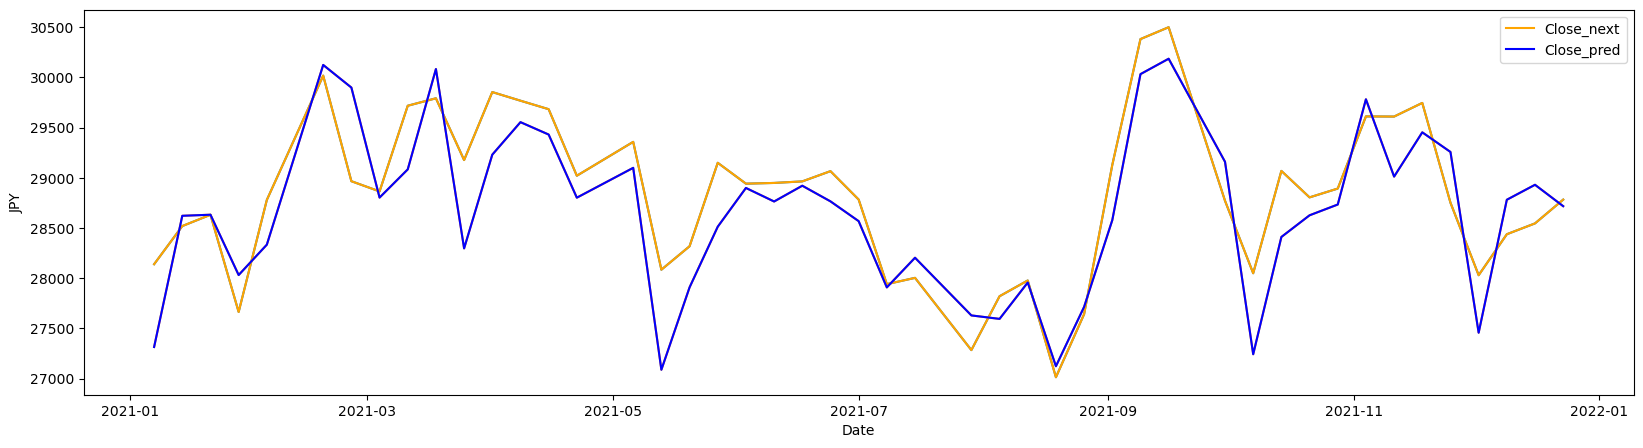

In [13]:
### 可視化で予測と実際の値を確認
df_result = test[['Close_next']]
df_result['Close_pred'] = y_pred

# 実際のデータと予測データの比較グラフ作成
plt.figure(figsize=(20, 5))
plt.plot(df_result[['Close_next', 'Close_pred']])
plt.plot(df_result['Close_next'], label='Close_next', color='orange')
plt.plot(df_result['Close_pred'], label='Close_pred', color='blue')
plt.xlabel('Date')
plt.ylabel('JPY')
xmin = df_result.index.min()
xmax = df_result.index.max()
plt.legend()
plt.show()

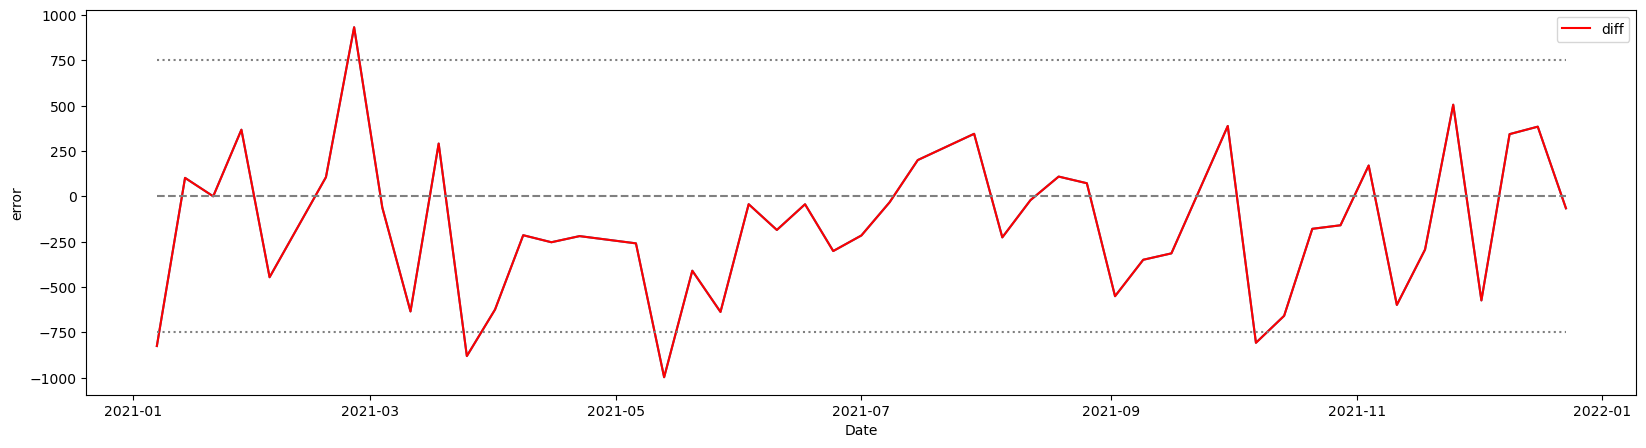

In [14]:
# 誤差を算出
df_result['diff'] = df_result['Close_pred'] - df_result['Close_next']

# 誤差のグラフ作成
plt.figure(figsize=(20, 5))
plt.plot(df_result[['diff']])
plt.plot(df_result['diff'], label='diff', color='red')
plt.xlabel('Date')
plt.ylabel('error')
plt.hlines(0, xmin, xmax, color='gray', linestyle='--')
plt.hlines(750, xmin, xmax, color='gray', linestyle=':')
plt.hlines(-750, xmin, xmax, color='gray', linestyle=':')
plt.legend()
plt.show()

### 予測モデルの係数と切片を確認

In [15]:
# 予測モデルの係数を確認
coef = pd.DataFrame(model.coef_) # データフレームの作成
coef.index = X_train.columns     # 項目名をインデックスに設定
coef

,0
High,-2.484147e-01
Low,-9.236032e-02
Open,5.350314e+10
Close,-5.350314e+10
Body,5.350314e+10
Close_diff,2.587886e-01
SMA1,-2.694607e-01
SMA2,-1.519496e-01
SMA3,4.855187e-02


In [16]:
# 予測モデルの切片を確認
model.intercept_

410.18951670336537

In [17]:
# X_train基本統計量の確認
X_train.describe()

,High,Low,Open,Close,Body,Close_diff,SMA1,SMA2,SMA3
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,22298.102686,22065.494843,22202.529083,22174.560721,-27.968362,22197.865382,22173.247346,22164.036962,22154.239021
std,1559.027597,1602.983382,1558.689896,1593.250387,162.247579,1558.574905,1548.152452,1500.769909,1451.165968
min,17160.970703,16358.190430,16995.769531,16552.830078,-570.169922,16726.550781,16944.800000,17647.499023,17983.368750
25%,21488.967773,21287.489746,21404.336914,21348.322754,-114.844238,21345.084473,21279.394238,21398.351172,21356.857747
50%,22285.825195,22065.250000,22189.254883,22191.609375,-21.565430,22167.609375,22177.097070,22088.985742,22103.505404
75%,23203.060547,22888.586914,23110.392090,23023.372559,68.228027,23121.364258,23138.541797,23093.306494,23126.927311
max,26868.089844,26719.230469,26744.500000,26809.369141,371.429688,26817.939453,26727.373828,26697.680859,26696.868490
